# Audio CWE Demonstration 
## The combined watermarking method & CatMap-based Permutation
The following notebook demonstrates the commutativity of the encryption and watermarking functions of the proposed method. It is shown, that the mark can be inserted in an encrypted cover work and after the decryption process it can still be verified correctly: 
$$ V(D_K(M(E_K(C_0),m)))= m$$

In [1]:
# Imports some dependencies
%matplotlib inline
import soundfile as sf
import numpy as np
import scipy
import math 
import matplotlib.pyplot as plt
from os import path, makedirs


In [2]:
# Imports the module, which implements the proposed method
%cd ../
from core.audio_cwe.xs_wm_scheme import XsWMSystem
from core.audio_cwe import watermarking_utils
from core.audio_cwe import catmap_encryption

/Users/gru/Documents/skripte/CSM/scripts/ws_15_16/38777 Masterthesis/src/audio_cwe_framework


### 1. Encryption $E_K(C_0)$
The original audio is written and encrypted via Arnold's CatMap

In [3]:
# Specify .wav-file to load
input_file = '../res/testing/original_test_files/SQAM/46.wav'
filename = input_file[0:len(input_file)-4].rsplit('/',maxsplit=1)[-1]
output_dir = path.join('..', input_file.split('/')[1], 'demo/notebooks/commutativity')
print(output_dir)
makedirs(output_dir, exist_ok=True)

# Read audio file 
orig_samples, samplerate = sf.read(input_file, dtype=np.int16)

# Key material
a = 75
b = 33
n = 3

# Encrypt audio file
cipher_samples, padding_length = catmap_encryption.encrypt(orig_samples,  a, b, n)
output_file_1 = path.join(output_dir, filename +'_encrypted.wav')
# Write it to disk
sf.write(output_file_1, cipher_samples, samplerate)


../res/demo/notebooks/commutativity


To illustrate the effect of the encryption process, the waveforms (amplitude over time) of the original and resulting signal are plotted:

In [4]:

def psnr(samples_a, samples_b):
    """Calcuates PSNR in dB """
    # Convert to 64-bit integers to prevent potential integer overflow
    samples_a= samples_a.astype(np.int64)
    samples_b= samples_b.astype(np.int64)
    
    # Calculates MSE        
    noise = np.mean((samples_a-samples_b)**2)
    
    if(noise == 0):
        return math.inf
    
    # Gather maximum amplitude in signal a 
    peak = np.amax(samples_a)
    
    return 10 * np.log10(peak**2 / noise)
    

PSNR of encrypted signal:     15.2172863992
PSNR of original signal:     inf


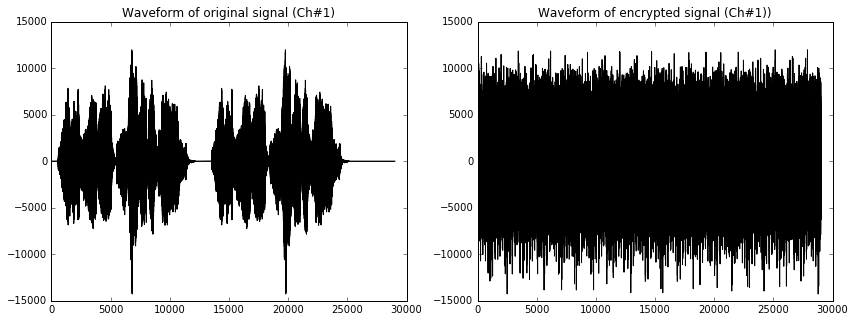

In [5]:
# Print PSNR of original signal and marked signal
psnr_enc = psnr(cipher_samples[0:len(orig_samples)], orig_samples)
print('PSNR of encrypted signal:    ', psnr_enc)
psnr_orig = psnr(orig_samples, orig_samples)
print('PSNR of original signal:    ', psnr_orig)

# Plot the waveforms of original cover work and encrypted work side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax = axes.flat
timeArray = np.arange(0, len(orig_samples), 1)#contains sample number (0,1,2,3,...)
timeArray = timeArray / samplerate #contains time label in seconds
timeArray = timeArray * 1000  #scale to milliseconds

#ax0.set_ylim([np.amin(samples), np.amax(samples)+1])
ax[0].plot(timeArray, orig_samples, color='k')
ax[0].set_title("Waveform of original signal (Ch#1)")

timeArray = np.arange(0, len(cipher_samples), 1)#contains sample number (0,1,2,3,...)
timeArray = timeArray / samplerate #contains time label in seconds
timeArray = timeArray * 1000  #scale to milliseconds

#ax1.set_ylim([np.amin(samples), np.amax(samples)+1])
ax[1].plot(timeArray, cipher_samples ,color='k') 
ax[1].set_title("Waveform of encrypted signal (Ch#1))") 



plt.show()


### 2. Watermarking via the combined method $M(E_K(C_0),m)$

In [6]:
# Read encrypted audio file 
cipher_samples, samplerate = sf.read(output_file_1, dtype=np.int16)

# Construct mark
w = watermarking_utils.construct_watermark(['HdM', 'Stg'])
wmk_length = len(w[0])
syn = w[:, :8]

# Construct embedder
wm_sys = XsWMSystem(threshold=30, la=2.2, num_bins=wmk_length*10)
# Mark encrypted samples 
marked_samples, bp = wm_sys.embed_watermark(cipher_samples, w, key=0xFF) 
wm_params = wm_sys.get_params()

# Write marked audio back
output_file_2 = path.join(output_dir, filename +'_encrypted_marked.wav')
sf.write(output_file_2, marked_samples, samplerate)

name_prefix = filename + '_marked'
watermarking_utils.dump_params(output_dir, name_prefix, iv=wm_params, key=bp, mark=w)

Embedding  [[0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1]
 [0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1]]  via combined method
---------------------------------------------
965.021184198
in channel # 0
---------------------------------------------
886.314234877
in channel # 1
---------------------------------------------


To illustrate the effect of the marking process the histograms (as used by Xiang's method) and waveforms  of the encrypted, unmarked and the resulting (encrypted, marked) signal are plotted

2.2 240 [965.02118419807982, 886.31423487739232]


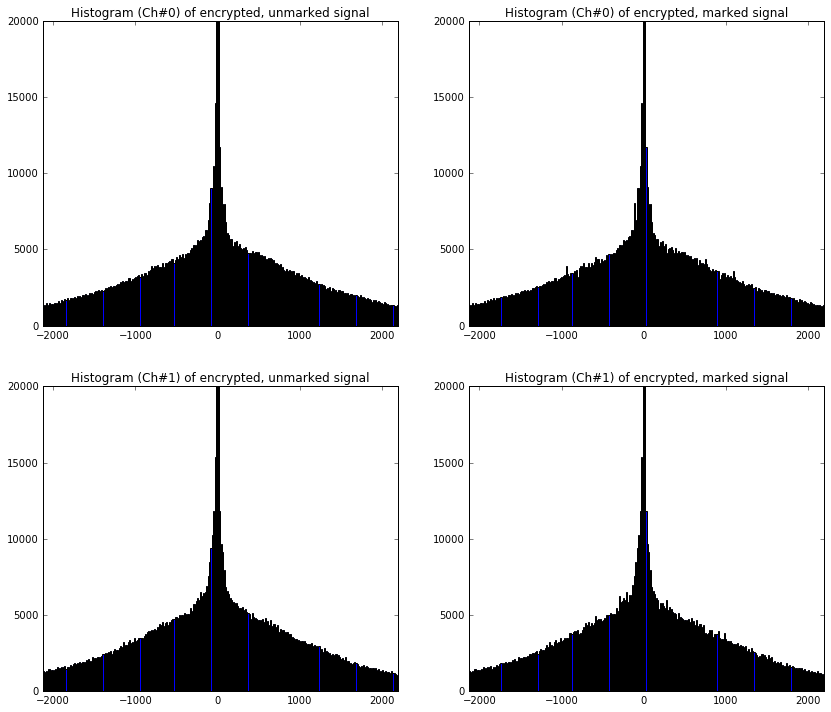

In [7]:
# Plot the histograms of the encrypted signal and the encrypted and marked signal
print(wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'])
hist0, bins0 = XsWMSystem.generate_histogram(cipher_samples[:, 0], wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'][0])
hist1, bins1 = XsWMSystem.generate_histogram(marked_samples[:, 0], wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'][0])
hist2, bins2 = XsWMSystem.generate_histogram(cipher_samples[:, 1], wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'][0])
hist3, bins3 = XsWMSystem.generate_histogram(marked_samples[:, 1], wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'][0])

width0 = 0.7 * (bins0[1] - bins0[0])
center0 = (bins0[:-1] + bins0[1:]) / 2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
ax = axes.flat
ax[0].bar(center0, hist0, align='center', width=width0)
ax[0].set_title("Histogram (Ch#0) of encrypted, unmarked signal")
ax[0].set_ylim(0,20000)
ax[0].set_xlim(bins0[0],bins0[-1])

ax[1].bar(center0, hist1, align='center', width=width0)
ax[1].set_title("Histogram (Ch#0) of encrypted, marked signal")
ax[1].set_ylim(0,20000)
ax[1].set_xlim(bins0[0],bins0[-1])

ax[2].bar(center0, hist2, align='center', width=width0)
ax[2].set_title("Histogram (Ch#1) of encrypted, unmarked signal")
ax[2].set_ylim(0,20000)
ax[2].set_xlim(bins0[0],bins0[-1])

ax[3].bar(center0, hist3, align='center', width=width0)
ax[3].set_title("Histogram (Ch#1) of encrypted, marked signal")
ax[3].set_ylim(0,20000)
ax[3].set_xlim(bins0[0],bins0[-1])

plt.show()

### 3. Decryption $D_K(M(E_K(C_0),m))$

In [8]:
# Reads marked and encrypted audio file
encrypted_marked, samplerate = sf.read(output_file_2, dtype=np.int16)
# Decrypts marked audio file
decrypted_samples = catmap_encryption.decrypt(encrypted_marked, padding_length, a, b, n)
output_file_3 = path.join(output_dir, filename +'_marked_decrypted.wav')
sf.write(output_file_3, decrypted_samples, samplerate)
psnr_enc = psnr(orig_samples, decrypted_samples)
print('PSNR of decrypted, marked signal:    ', psnr_enc)



PSNR of decrypted, marked signal:     53.5429264268


The histograms and waveforms of the encrypted, marked and the decrypted, marked signal are plotted, which shows the negligible of the removal of the padding samples effect on the histogram.

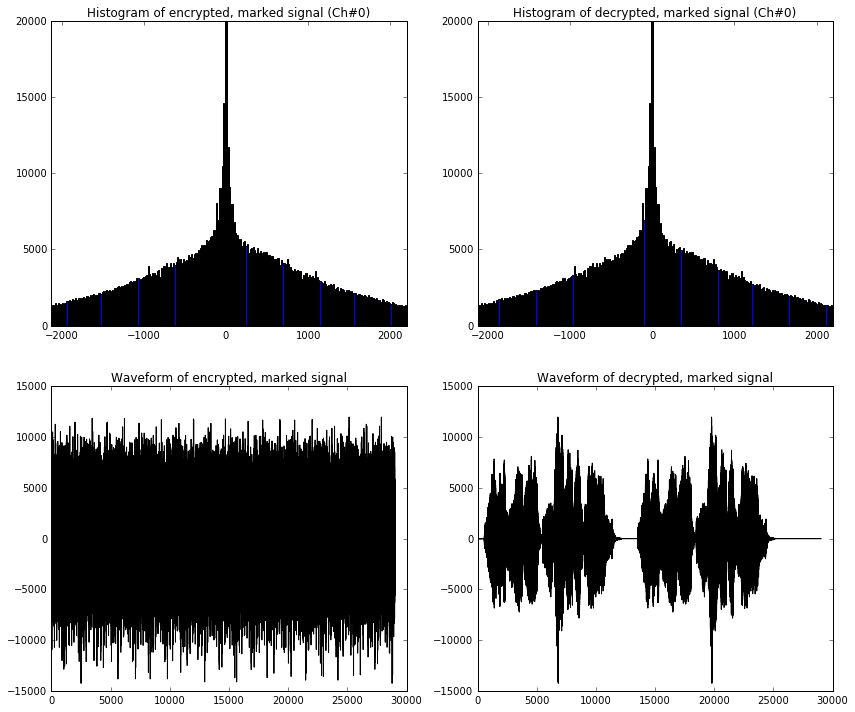

In [9]:
# Plots the histograms and waveforms of the encrypted, marked signal and the decrypted, marked signal
hist0, bins0 = XsWMSystem.generate_histogram(encrypted_marked[:,0], wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'][0])
hist1, bins1 = XsWMSystem.generate_histogram(decrypted_samples[:,0], wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'][0])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
ax = axes.flat
ax[0].bar(center0, hist0, align='center', width=width0)
ax[0].set_title("Histogram of encrypted, marked signal (Ch#0)")
ax[0].set_ylim(0,20000)
ax[0].set_xlim(bins0[0],bins0[-1])
ax[1].bar(center0, hist1, align='center', width=width0)
ax[1].set_title("Histogram of decrypted, marked signal (Ch#0)")
ax[1].set_ylim(0,20000)
ax[1].set_xlim(bins0[0],bins0[-1])

timeArray = np.arange(0, len(encrypted_marked), 1)#contains sample number (0,1,2,3,...)
timeArray = timeArray / samplerate #contains time label in seconds
timeArray = timeArray * 1000  #scale to milliseconds

#ax0.set_ylim([np.amin(samples), np.amax(samples)+1])
ax[2].plot(timeArray, encrypted_marked, color='k')
ax[2].set_title("Waveform of encrypted, marked signal")

timeArray = np.arange(0, len(decrypted_samples), 1)#contains sample number (0,1,2,3,...)
timeArray = timeArray / samplerate #contains time label in seconds
timeArray = timeArray * 1000  #scale to milliseconds

#ax1.set_ylim([np.amin(samples), np.amax(samples)+1])
ax[3].plot(timeArray, decrypted_samples ,color='k') 
ax[3].set_title("Waveform of decrypted, marked signal") 

plt.show()

### 4. Verification $V(D_K(M(E_K(C_0),m)))=m$

In [10]:
# Reads decrypted and marked audio file and verifies mark
marked_samples, samplerate = sf.read(output_file_3, dtype=np.int16)

# Read IV and construct the detector
wm_sys = XsWMSystem.from_file(path.join(output_dir, filename +'_marked_iv'))  # key and mark could be read from disk as well
# Read the mark to form the syn code
mark = np.loadtxt(path.join(output_dir, filename +'_marked_mark'), dtype=np.int)
syn = mark[:, :8]
# Read the key
detection_key = watermarking_utils.read_keyfile(path.join(output_dir, filename +'_marked_key_('+str(len(marked_samples[0]))+', '+ str(len(mark[0]))+', 2)'))
# Extract the mark
w_2 = wm_sys.extract_watermark(marked_samples, key=bp, syn=syn)


# Check, whether the detected watermark is correct
print('\n\n')
print('=============================================')
print('Result:')
print('---------------------------------------------')
if np.array_equal(w, w_2):
    print('Original watermark and detected watermark match perfectly')
else:
    print('Original watermark and detected watermark do not match ')

print('---------------------------------------------')
print (w)
print (w_2)


Detecting watermark
---------------------------------------------
in channel # 0
---------------------------------------------
---------------------------------------------
Syn:
 [0 1 0 0 1 0 0 0]
Best match:
 [0 1 0 0 1 0 0 0]
Mean:  964.95194317
---------------------------------------------
in channel # 1
---------------------------------------------
---------------------------------------------
Syn:
 [0 1 0 1 0 0 1 1]
Best match:
 [0 1 0 1 0 0 1 1]
Mean:  886.089432224
---------------------------------------------



Result:
---------------------------------------------
Original watermark and detected watermark match perfectly
---------------------------------------------
[[0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1]
 [0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1]]
[[0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1]
 [0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1]]


Compare the marked cover work and the original one:

PSNR of marked signal:     53.5429264268


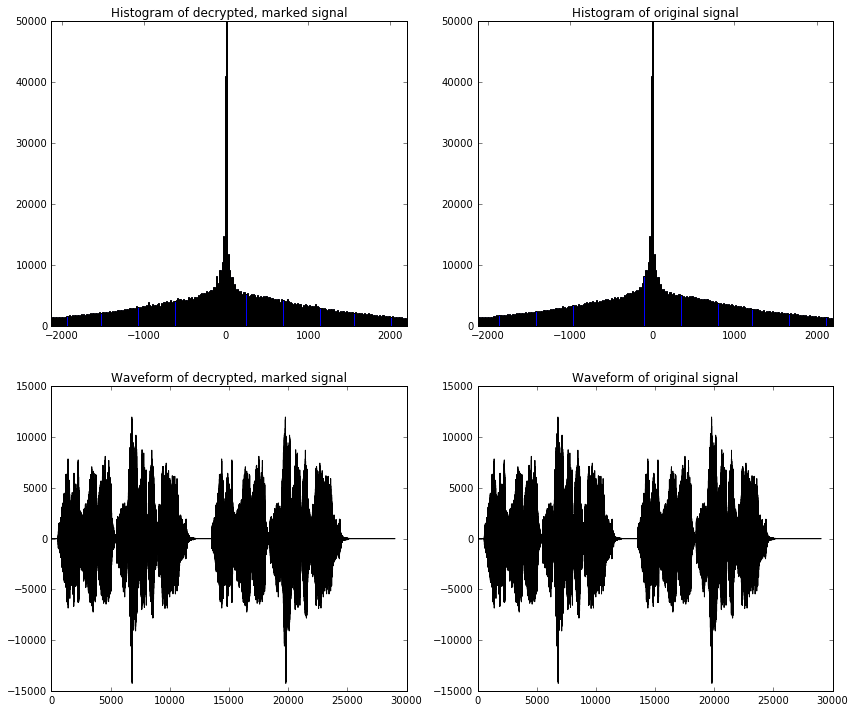

In [11]:

# Prints PSNR of original signal and marked signal
psnr_marked = psnr(marked_samples, orig_samples)
print('PSNR of marked signal:    ', psnr_marked)


# Plots the histograms and waveforms of the decrypted, marked signal and original unmarked signal
hist0, bins0 = XsWMSystem.generate_histogram(marked_samples[:,0], wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'][0])
hist1, bins1 = XsWMSystem.generate_histogram(orig_samples[:,0], wm_params['la'], wm_params['num_bins'], wm_params['orig_mean'][0])
width0 = 0.7 * (bins0[1] - bins0[0])
center0 = (bins0[:-1] + bins0[1:]) / 2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
ax = axes.flat
ax[0].bar(center0, hist0, align='center', width=width0)
ax[0].set_title("Histogram of decrypted, marked signal")
ax[0].set_ylim(0,50000)
ax[0].set_xlim(bins0[0],bins0[-1])

ax[1].bar(center0, hist1, align='center', width=width0)
ax[1].set_title("Histogram of original signal")
ax[1].set_ylim(0,50000)
ax[1].set_xlim(bins0[0],bins0[-1])

timeArray = np.arange(0, len(marked_samples), 1)#contains sample number (0,1,2,3,...)
timeArray = timeArray / samplerate #contains time label in seconds
timeArray = timeArray * 1000  #scale to milliseconds

#ax0.set_ylim([np.amin(samples), np.amax(samples)+1])
ax[2].plot(timeArray, marked_samples, color='k')
ax[2].set_title("Waveform of decrypted, marked signal")

timeArray = np.arange(0, len(marked_samples), 1)#contains sample number (0,1,2,3,...)
timeArray = timeArray / samplerate #contains time label in seconds
timeArray = timeArray * 1000  #scale to milliseconds

#ax1.set_ylim([np.amin(samples), np.amax(samples)+1])
ax[3].plot(timeArray, orig_samples ,color='k') 
ax[3].set_title("Waveform of original signal") 

plt.show()